<a href="https://colab.research.google.com/github/thaleson/datascience/blob/main/Detec%C3%A7%C3%A3o_de_Fraude_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


#### **Data Science**


---

# Detecção de Fraudes em Cartões de Crédito

Neste projeto, irei abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. Apenas no Brasil, cerca de 12,1 milhões de pessoas já foram vítimas de algum tipo de fraude financeira no último ano. Traduzindo em valores, os golpes financeiros ultrapassaram a cifra de R$ 1,8 bilhão de prejuízo por ano para os últimos 12 meses.

<p align=center>
<img src="https://images.unsplash.com/photo-1592772874383-d08932d29db7?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=699&q=80" width="60%"></p>

Dentra essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acaretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*.

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de Reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## Importando os Dados

Os dados que usei neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$

<p align=center>
<img src="https://images.unsplash.com/photo-1620714223084-8fcacc6dfd8d?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1051&q=80" width="50%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [4]:
#@title
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# instalar a biblioteca scikit-plot
!pip install -q scikit-plot

In [5]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')


Para facilitar a aquisição dos dados, criei um *link* com acesso direto ao `csv`. Com isso, basta importar o conjunto de dados usando o método `pd.read_csv()`.

In [2]:
# importar os dados para um dataframe
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"




In [6]:
df=pd.read_csv(file_path)

## Análise Exploratória

Apenas olhando as cinco primeiras entradas é possível tirar algumas conclusões:

* As 5 primeiras entradas permitem entender como a transformação PCA deixou as *features* descaracterizadas (anônimas) e em valores numéricos. Para saber mais sobre PCA, [clique neste *link*](http://www2.ic.uff.br/~aconci/PCA-ACP.pdf).

* As colunas `Time` e `Amount` foram preservadas, mantendo seu valor original.

* A variável alvo está representada na coluna `Class`, onde:
    * **0:** Transação normal; e
    * **1:** Transação fraudulenta;

# As 5 primeiras **entradas**

In [ ]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Verificando abaixo o resumo estatístico, por meio do método `describe()`, podemos confirmar que as variáveis relativas aos componentes principais (transformação PCA) não têm nenhuma discrepância aparente, bem como a coluna `Time`.

Em relação à variável `Amount`, nota-se que o valor médio de transações (considerando ambas as classes) é 88.34, mediana igual a 22.00 e desvio padrão de 250.12. Atingindo o valor máximo de 25691.16, a maioria das transações financeiras é composta em sua maioria por quantias menores - como esperado.



# **resumo estatístico**

In [10]:
#Ver o resumo estatístico do dataframe
df.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Quanto à qualidade do *dataset*, este não apresentou nenhum valor ausente ou que demandasse uma etapa de limpeza. Na função abaixo, perceba que o maior valor por coluna para valores nulos é zero, o que confirma que não há valores ausentes.

In [11]:

# ver se há valores ausentes
df.isnull().sum().max()

0

Como é [informado na descrição dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), as entradas relativas à transações fraudulentas correspondem a 0,17% do total.

O gráfico de barras mostra como essa discrepância se torna nítida e visível. Na prática, isso interfere no desempenho do modelo, e será necessário fazer um balanceamento dos dados antes de alimentar o modelo final de classificação.

0    284315
1       492
Name: Class, dtype: int64

Fraudes representam 0.1727% do dataset.



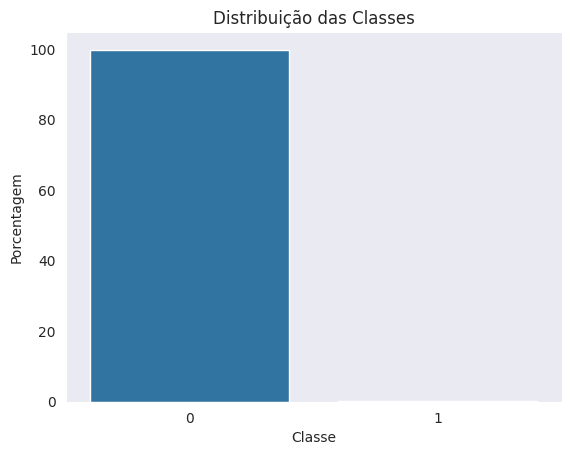

In [9]:
# ver o balanceamento das classes
print(df.Class.value_counts())
print("\nFraudes representam {:.4f}% do dataset.\n".format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))
# Calcular a porcentagem de fraudes no dataset
fraud_percentage = df['Class'].value_counts(normalize=True) * 100
# Plotar gráfico de barras para as classes
sns.barplot(x=fraud_percentage.index, y=fraud_percentage.values)

# Adicionar rótulos
plt.title('Distribuição das Classes')
plt.xlabel('Classe')
plt.ylabel('Porcentagem')

# Exibir o gráfico
plt.show()

Plotou-se também dois gráficos a fim de comparar as distribuições das 2 classes ao longo da dimensão tempo (`Time`). No entanto, não foi identificada nenhum informação a partir das distribuições de frequência abaixo.

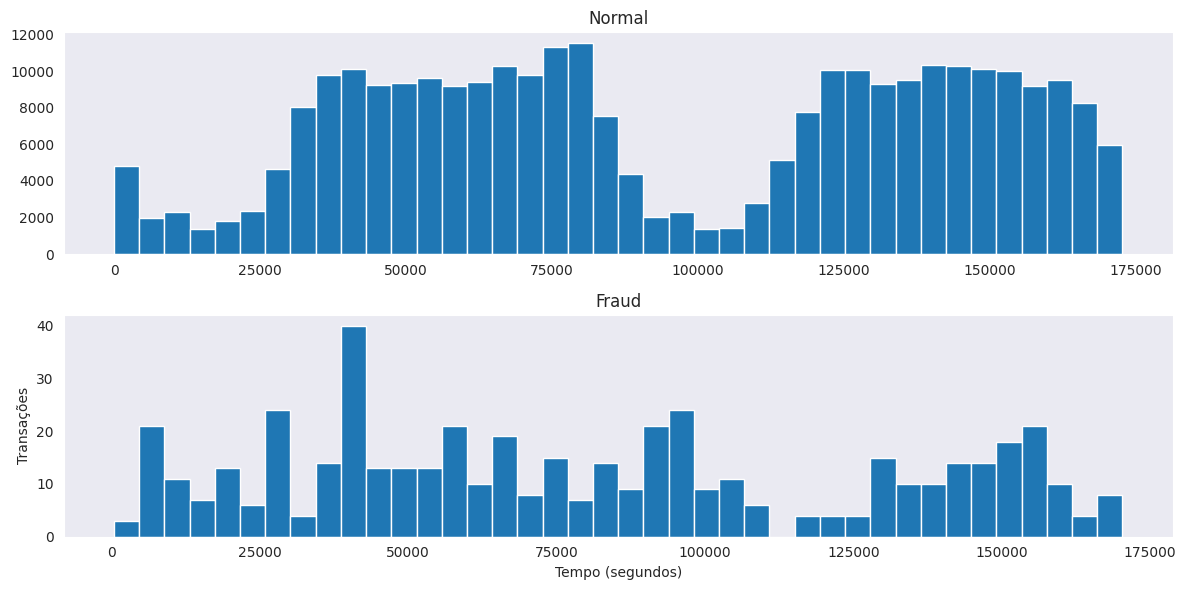

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

num_bins = 40

ax[0].hist(df.Time[df.Class == 0], bins=num_bins)
ax[0].set_title('Normal')

ax[1].hist(df.Time[df.Class == 1], bins=num_bins)
ax[1].set_title('Fraud')

plt.xlabel('Tempo (segundos)')
plt.ylabel('Transações')
plt.tight_layout()

Seguindo a análise exploratória, plotou-se os *boxplots* para ver se há alguma diferença no padrão transações em relação à dimensão `Amount`.

De uma maneira geral, percebe-se uma distribuição diferente para as duas classes, o que provavelmente irá contribuir para o treinamento do modelo de *machine learning*.

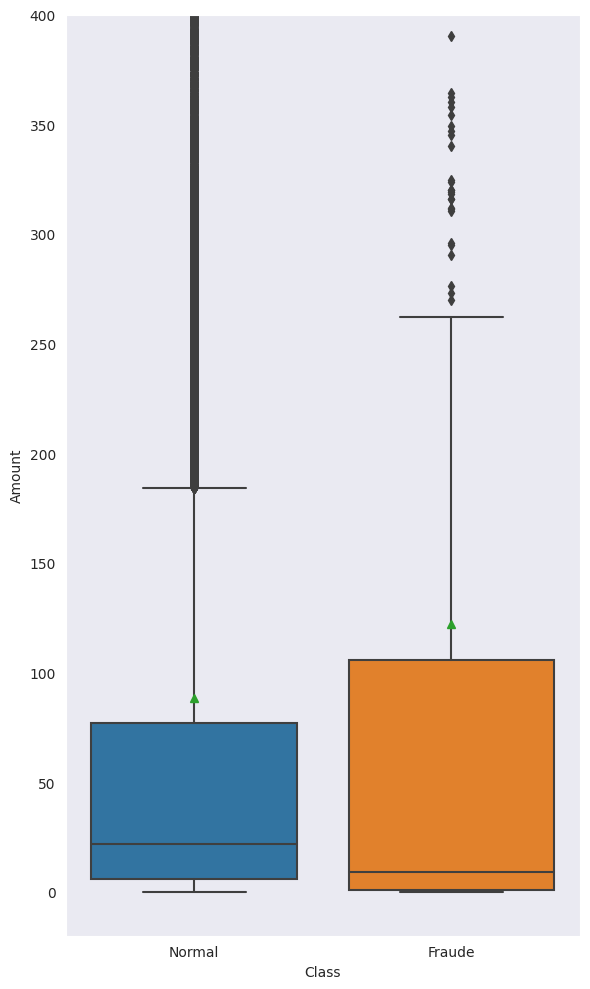

In [16]:
fig, ax = plt.subplots(figsize=(6, 10), sharex=True)
sns.boxplot(x='Class', y='Amount', data=df, showmeans=True, ax=ax)
plt.ylim((-20, 400))
plt.xticks([0, 1], ['Normal', 'Fraude'])
plt.tight_layout()
plt.show()

As informações estatísticas para df.Class == 1 mostram que a sua média exata está em 123.70 e a mediana em 11.40.

In [17]:
df[(df.Class == 1) & (df.Amount < 2000)]['Amount'].describe()

count     491.000000
mean      118.130550
std       240.439028
min         0.000000
25%         1.000000
50%         9.210000
75%       105.350000
max      1809.680000
Name: Amount, dtype: float64

O gráfico de densidade é muito útil para compararmos as distribuições de cada variável para cada classe e ver quais as mais importantes para detecção de anomalias.

O que se procura nesse tipo de visualização são distribuições que diferem uma da outra, permitindo identificar fraudes mais facilmente. Veja como exemplo as variáveis V3, V4, V10 e V11, como elas são bem distintas.

Por outro lado, variáveis como V8, V13 e V15 são muito similares, apresentando aproximadamente o mesmo comportamento.

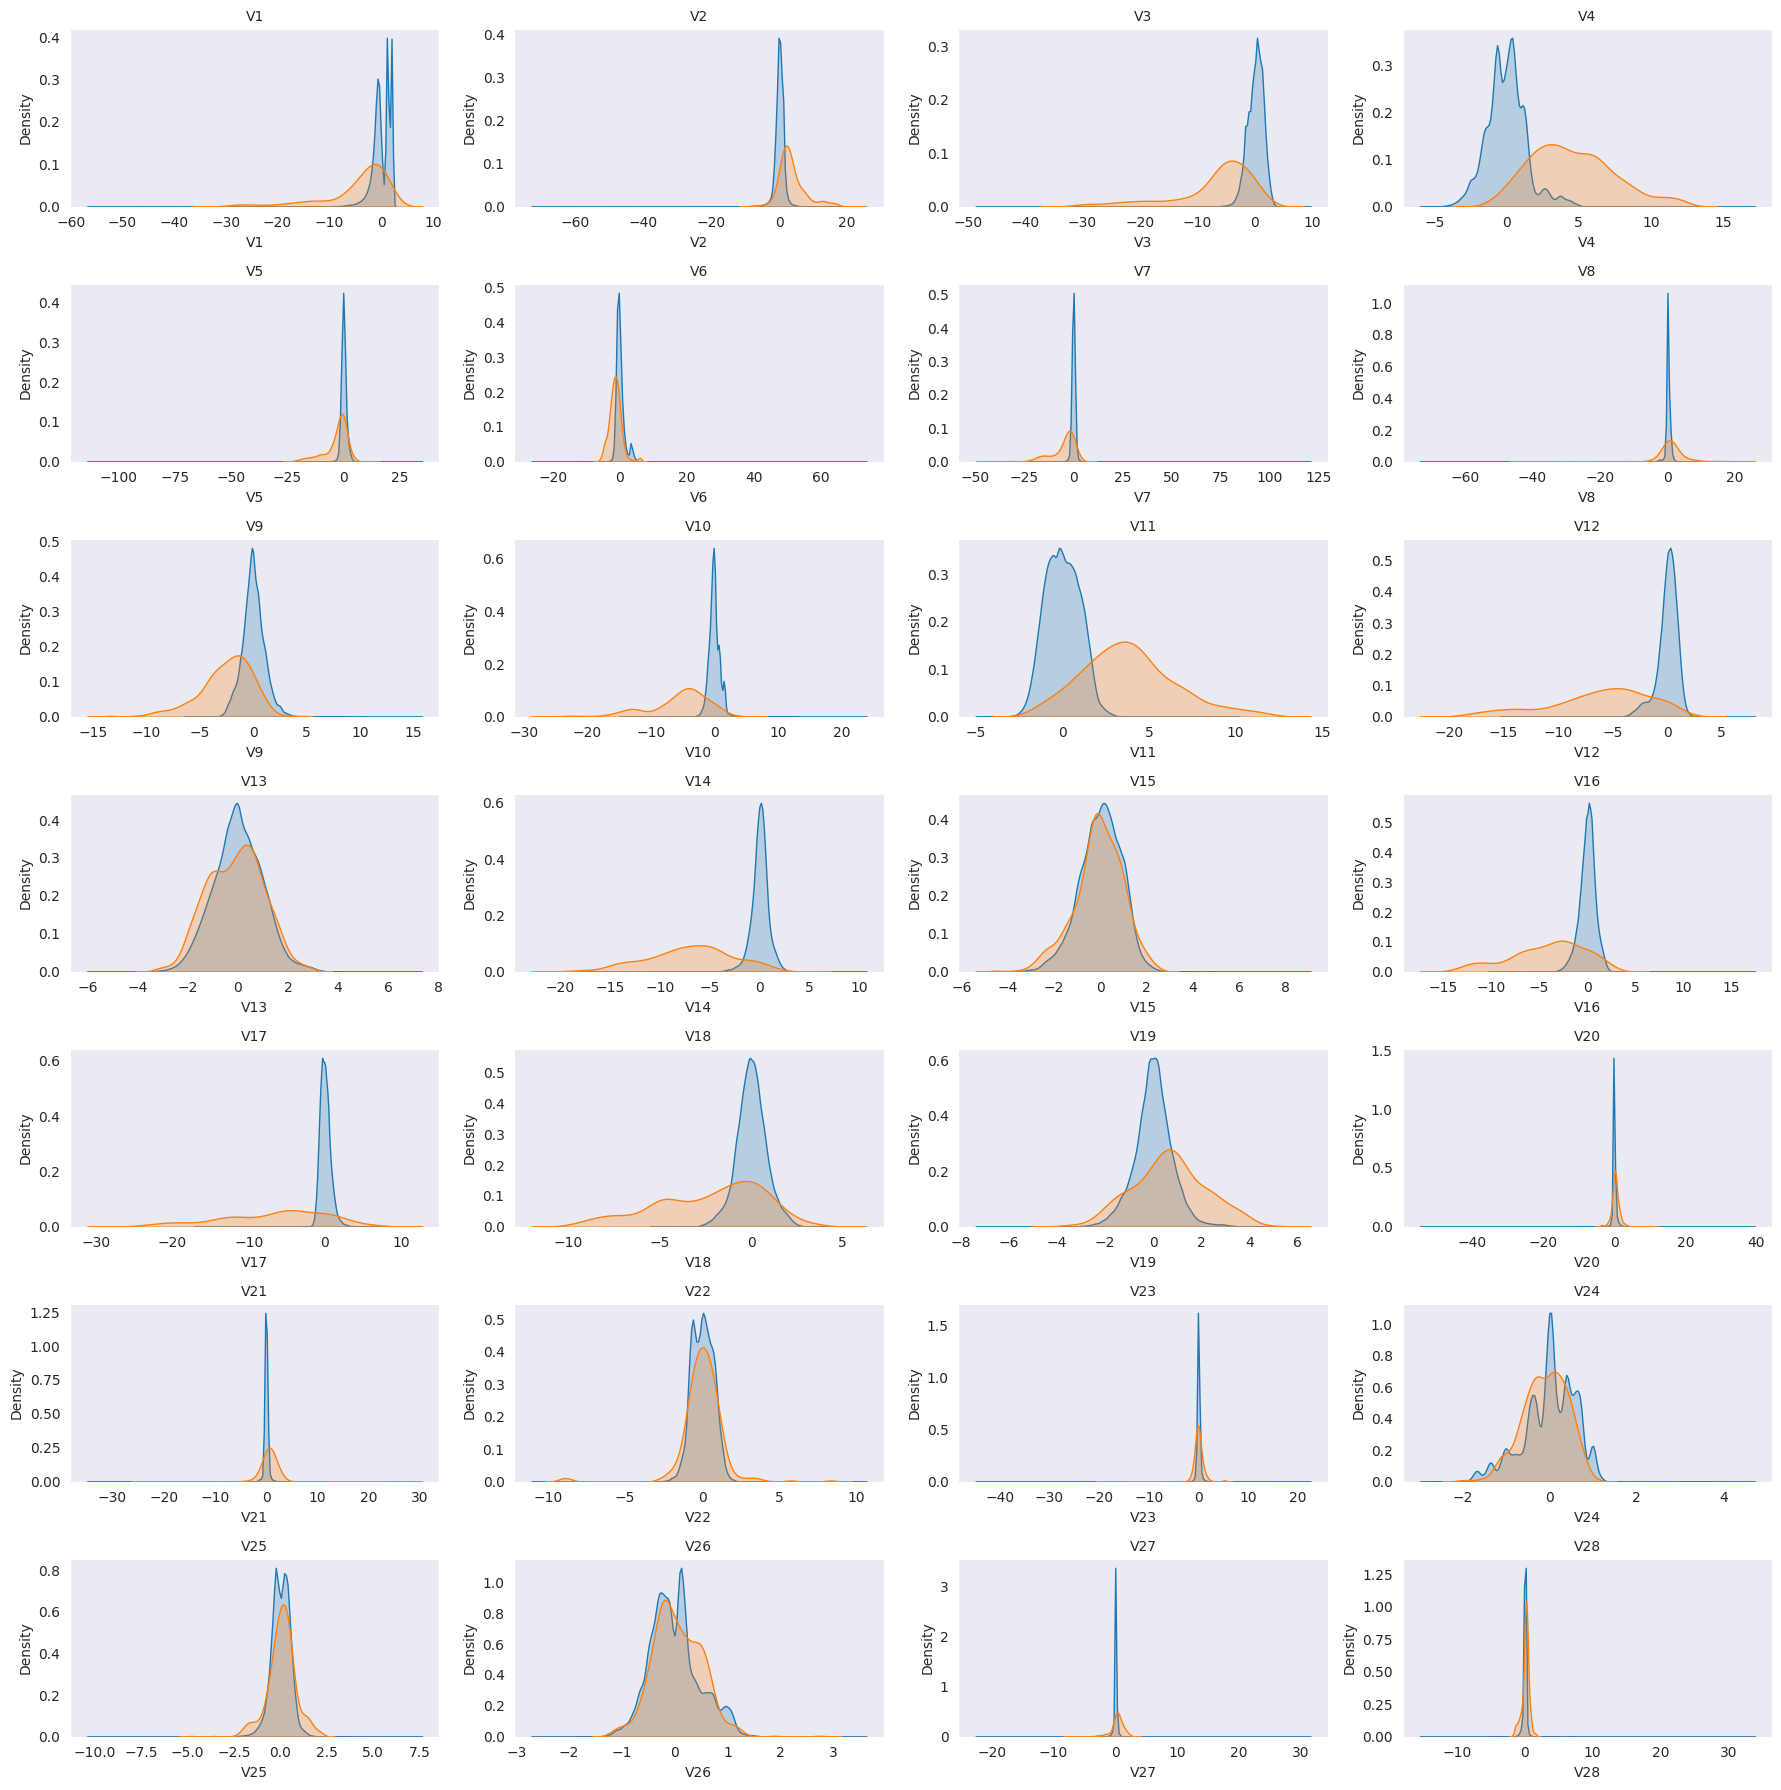

In [18]:
column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
    sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()


Resumidamente, algumas observações principais que puderam ser extraídas dessa etapa exploratória foram:

* O *dataset* está muito desbalanceado, uma vez que as transações fraudulentas representam apenas 0,17% das entradas totais.
* Não existem valores ausentes ou nulos no *dataframe*.
* Uma vez que a PCA é sensível à escala das variáveis, assume-se a premissa que as *features* originais foram padronizadas.
* As colunas `Time` e `Amount` não estão normalizadas.

# Preparando os **dados**



Para que os dados possam alimentar o modelo de Regressão Logística que iremos construir, nesta etapa de preparação iremos:

* Padronizar as *features* `Time` e `Amount`, que estão em outra ordem de grandeza.
* Dividir entre dados de treino e teste
* Balancear os dados a fim de evitar uma baixa performance para a classe 1 e *overfitting*.

**Padronizar `Time` e `Amount`**

Para esta etapa, uma vez que a coluna `Amount` possui *outliers* será usada a padronização por meio da classe `StandardScaler`

In [ ]:
#importação das bibliotecas
!pip install scikit-learn
!pip install imbalanced-learn
from sklearn.preprocessing import MinMaxScaler



In [21]:
# Criar uma cópia do DataFrame para evitar modificar o original
df_normalized = df.copy()

# Inicializar o MinMaxScaler
scaler = MinMaxScaler()

# Normalizar as colunas 'Time' e 'Amount'
df_normalized[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

# Exibir as primeiras linhas do DataFrame normalizado
df_normalized.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.005824,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.000105,0
2,0.000006,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.014739,0
3,0.000006,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.004807,0
4,0.000012,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.002724,0


**Dividir entre conjuntos de Treino e Validação**

Antes de proceder com o balanceamento de dados, devemos splitar os dados já existentes entre Treino e Validação. Caso contrário, não teremos parâmetros para conferir se o balanceamento foi adequado.



In [ ]:
#Dividir o conjunto de dados entre treino e validação

from sklearn.model_selection import train_test_split


# Dividir os dados em features (X) e target (y)
X = df_normalized.drop('Class', axis=1)  # Features
y = df_normalized['Class']  # Target

# Dividir os dados entre treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Exibir as dimensões dos conjuntos de treino e validação
print("Dimensões dos conjuntos de treino:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nDimensões dos conjuntos de validação:")
print("X_valid:", X_valid.shape)
print("y_valid:", y_valid.shape)


Dimensões dos conjuntos de treino:
X_train: (227845, 30)
y_train: (227845,)

Dimensões dos conjuntos de validação:
X_valid: (56962, 30)
y_valid: (56962,)


**Balanceamento dos dados**

Usando a biblioteca `imblearn` é possível aplicar facilmente técnicas de balanceamento de dados. No caso, a opção neste projeto foi usar *Under-sampling*, preservando a classe minoritária.

É fácil ver que não há mais aquela discrepância inicial (gráfico de barras no início deste *notebook*).

In [ ]:
 #Balancear o conjunto de dados

import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Suponhamos que você já tenha carregado e pré-processado o DataFrame 'df_normalized'

# Dividir os dados em features (X) e target (y)
X = df_normalized.drop('Class', axis=1)  # Features
y = df_normalized['Class']  # Target

# Dividir os dados entre treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Inicializar o SMOTE para oversampling
smote = SMOTE(random_state=42)

# Aplicar oversampling apenas nos dados de treino
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Exibir as dimensões dos conjuntos após oversampling
print("Dimensões dos conjuntos de treino após oversampling:")
print("X_train_resampled:", X_train_resampled.shape)
print("y_train_resampled:", y_train_resampled.shape)


Dimensões dos conjuntos de treino após oversampling:
X_train_resampled: (454902, 30)
y_train_resampled: (454902,)


Com os dados balanceados, podemos ver a  correlação e identificar quais variáveis estão mais fortemente relacionadas com as outras.



## Modelo de Machine Learning

Com todos os dados preparados e após uma análise exploratória completa, irei construir um classificador usando a Regressão Logística.

Após instanciar o modelo, o mesmo será treinado em cima dos dados . Na sequência, serão realizadas as previsões sobre os dados de teste.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Acurácia: 0.97%


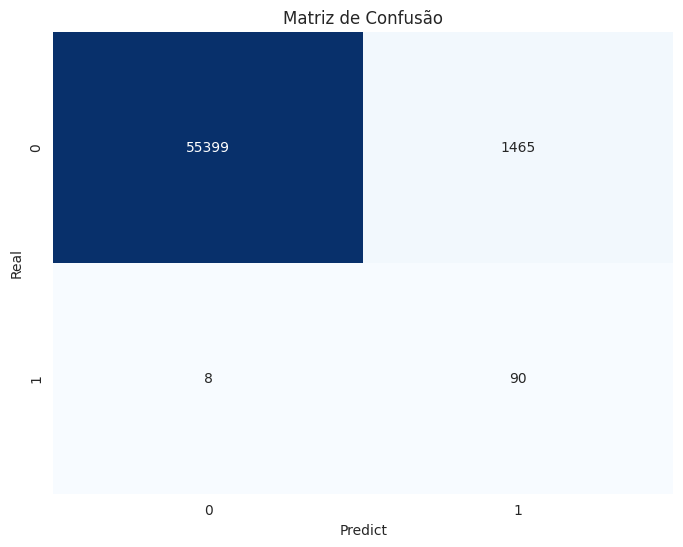

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Dividir os dados em features (X) e target (y)
X = df_normalized.drop('Class', axis=1)  # Features
y = df_normalized['Class']  # Target

# Dividir os dados entre treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Inicializar o SMOTE para oversampling
smote = SMOTE(random_state=42)

# Aplicar oversampling apenas nos dados de treino
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Inicializar o modelo de Regressão Logística
model = LogisticRegression(random_state=42)

# Treinar o modelo com os dados resampleados
model.fit(X_train_resampled, y_train_resampled)

# Fazer previsões nos dados de validação
y_pred = model.predict(X_valid)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)
class_report = classification_report(y_valid, y_pred)

# Exibir a Acuráciade avaliação
print(f"Acurácia: {accuracy:.2f}%")


# Plotar a Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Predict')
plt.ylabel('Real')
plt.show()



Podemos ver que nossos resultados foram marginalmente inferiores ao do conjunto de validação,A Acurácia foi de  0.97 porcento, O que é um excelente resultado!   .

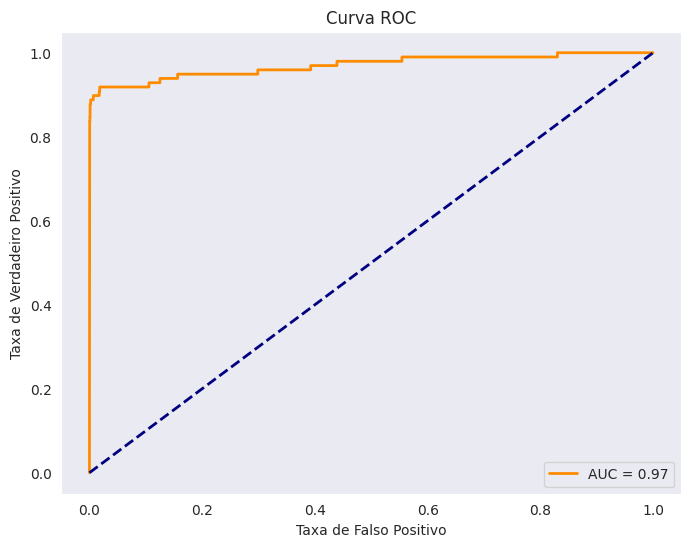

In [33]:
# Plotar a Curva ROC (Receiver Operating Characteristic)
from sklearn.metrics import roc_curve, auc

y_scores = model.predict_proba(X_valid)[:, 1]
fpr, tpr, _ = roc_curve(y_valid, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Vemos aqui nesse graficos Apresentado a Taxa de falso positivo e a Taxa de Verdadeiro Positivo


#Avaliar o desempenho do modelo

Vamos avaliar agora nosso modelo com resultado final!

In [ ]:
#Avaliar o desempenho do modelo
from sklearn.metrics import recall_score
y_pred = model.predict(X_valid)

# Avaliar o desempenho do modelo usando Recall
recall = recall_score(y_valid, y_pred)

# Exibir a métrica Recall
print(f"Recall: {recall:.4f}")

Recall: 0.9184


O resultado perdeu pouco de precisão ,mas ainda assim  é um excelente resultado!   .


Conclusões:

Recall Significativo: Um recall de 0.9184 é bastante elevado e sugere que o modelo está sendo eficaz em identificar a maioria das transações fraudulentas. Isso é crítico para a detecção de fraudes, pois erros que resultam em falsos negativos podem ter consequências graves.

Validação Cruzada e Ajuste de Hiperparâmetros: Se possível, considere a aplicação de validação cruzada e ajuste de hiperparâmetros para garantir que o desempenho do modelo seja consistente em diferentes divisões dos dados e que os parâmetros do modelo estejam otimizados.

Impacto do Desequilíbrio de Classes: Dada a natureza desbalanceada do conjunto de dados (muito mais transações não fraudulentas do que fraudulentas), é crucial usar métricas apropriadas para avaliar o desempenho do modelo. O oversampling (SMOTE) foi aplicado para lidar com esse desequilíbrio.

Em resumo, um recall de 0.9184 é uma indicação promissora de desempenho na detecção de fraudes, mas recomenda-se uma análise abrangente considerando várias métricas e uma compreensão do contexto específico do problema.